# Switching dynamical systems
by Magdalena Buszka, Martyna Firgolska, Karol Kuczmarz

## Motivation

Our main motivation for this project was to understand HMM and Normalizing Flows and combine this models in order to create a model that will be able to recognize hidden discrete variables (hidden states) given continous observable variables. 

## Our model

Our model consists on Hidden Markov Model combined with continuous probability distributions modeled and trained by Normalizing Flows (RealNVP).

### HMM

#### What is HMM?


HMM - Hidden Markov Model is based on Markov chain. Markov chain is a model used to predict sequence of discreete variables (states). It assumes that if we want to predict next state in a sequence then all that is important is current state. In other words it does not matter how we got into current state.  

In hidden markov model we assume that there are some hidden discreete states that form a markov chain. This hidden states dictate probabilities with which observable discreete vairables are drawn. Given sequences of observable variables hidden marcov model can be trained to create underlying marcov chain of hidden discreete states and most likely probablity distributions of observable variables for each hidden state. It is achieved using dynamic forward, backward and forward-backward algorithm. Given trained model and sequence of observable variables we can predict most likely hidden state sequence by using viterbi algorithm.

Good resource for learning more about HMMs: https://web.stanford.edu/~jurafsky/slp3/A.pdf

#### How we modified HMM for our use?

The classic Hidden Markov Model is used to model markov processed with discreete observable variables. However in our aplication we wanted our observable variables to be from continous distributions. This changes the theoretical model in two major ways. Firstly now instead of operating on probability of observation given hidden state we are using probablity density function (pdf). However this theoretical change does not change algorithms much. Secondly we need another way to model and train probabilities of observations for each state - this is where Normalizing Flows are used - they will be described in later section.

For testing purposes for HMM model we used torch.distributions as a way to model probablity distributions of observations for each state and did not train them. Instead we focused on training transition matrix, since training for distributions will be part of normalizing flow model.

We modified code from
https://github.com/lorenlugosch/pytorch_HMM
We changed emission model to be continous distribution. We also added backward and forward-backward algorithms. All algorithms are written in log domain for better numerical stablility.

### HMM demo

In [4]:
# TODO imports
from models.hmm.HiddenMarkovModel import *
from models.hmm.ArtificialDatasetFromHMM import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

/home/martyna/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


#### Using HMM class to generate samples
HMM class can be used to generate samples. It takes observation distributions for each state as an argument. As a default it generates random transition matrix (but transition matrix can be given as an argument too).

1D samples

transition matrix:
 tensor([[0.2683, 0.7317],
        [0.7338, 0.2662]])
samples
 tensor([ 2.9232, -2.0618,  1.1482, -1.1245,  0.5543, -0.5431, -1.6209, -0.3294,
        -1.6251,  0.5588, -0.6268, -0.4577, -0.0465, -0.8909, -0.5054,  0.2506,
         0.1254, -1.8412,  1.0411, -2.1332])
hidden states:
 [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]


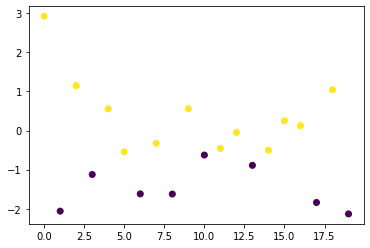

In [5]:
# two hidden states
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])
x, z = test_model.sample(20)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
print("samples\n", x)
print("hidden states:\n", z)
plt.scatter(list(range(len(x))),x, c=z)

transition matrix:
 tensor([[0.4615, 0.0718, 0.4668],
        [0.2197, 0.4638, 0.3164],
        [0.5363, 0.3013, 0.1624]])


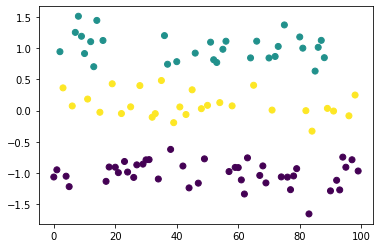

In [6]:
# three hidden states
test_model = HMM(3, [distrib.Normal(-1,0.2), distrib.Normal(1, 0.2), distrib.Normal(0,0.2)])
x, z = test_model.sample(100)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
plt.scatter(list(range(len(x))),x, c=z)

2D samples

transition matrix:
 tensor([[0.7289, 0.2711],
        [0.5681, 0.4319]])


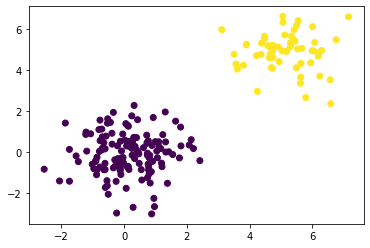

In [7]:
test_model = HMM(2, [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))])
x, z = test_model.sample(200)
print("transition matrix:\n", test_model.transition_model.normalized_transition_matrix())
plt.scatter(x[:,0],x[:,1], c=z)

##### Training HMMs
We use HMM model to generate samples and then train another HMM model on this data. We only use x (observable vairables) for training. 

In [10]:
sequence_length, n_of_sequences, sample_dim = 100, 1000, 2
batch_size = 500
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))],
    device, 
    T=n_of_sequences,
    sequence_length=sequence_length,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.7, 0.3]]))
samples = my_dataset[1:len(my_dataset)]


In [11]:
HMM_to_train = HMM(2,[distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))], 
                   transition_matrix = torch.Tensor([[0.49,0.51],[0.55, 0.45]]))
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Starting transition matrix:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])
Starting transition matrix:
 tensor([[0.4900, 0.5100],
        [0.5500, 0.4500]])


In [12]:
from torch.utils.data import DataLoader
# dataset is class inheriting from torch.utils.data.Dataset
for epoch in range(10):
    dataloader = DataLoader(my_dataset, batch_size= batch_size)
    for batch, x in enumerate(dataloader):
        T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
        HMM_to_train.forward_backward_step(x, T)
        #print(HMM_to_train.transition_model.normalized_transition_matrix())

In [13]:
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Transition matrix after training:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])
Transition matrix after training:
 tensor([[0.1049, 0.8951],
        [0.6990, 0.3010]])


##### Using viterbi algorithm on trained model
We draw samples from original HMM model and attempt to assign them hidden states using the viterbi algorithm on trained model and observable variables.

short sequence

In [39]:
sequence_length = 20
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob


tensor([[-64.2616]])

In [40]:
print("original states:  ", z)
print("predicted states: ",viterbi_states[0])

original states:   [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
predicted states:  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


long sequence

In [51]:
sequence_length = 200
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob


tensor([[-660.7247]])

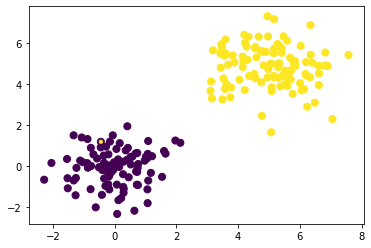

In [52]:
plt.scatter(x[:,0],x[:,1], c=z, s=50)
plt.scatter(x[:,0],x[:,1], c=viterbi_states[0], s=10)

### Normalizing Flows

## Other tests

### HMM training second example

In [82]:
sequence_length, n_of_sequences, sample_dim = 100, 1000, 2
batch_size = 500
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2),torch.eye(2))],
    device, 
    T=n_of_sequences,
    sequence_length=sequence_length,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.4, 0.6]]))
samples = my_dataset[1:len(my_dataset)]

In [83]:
HMM_to_train = HMM(2,[distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2),torch.eye(2))], 
                   transition_matrix = torch.Tensor([[0.45,0.55],[0.49, 0.51]]))
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Starting transition matrix:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.4000, 0.6000]])
Starting transition matrix:
 tensor([[0.4500, 0.5500],
        [0.4900, 0.5100]])


In [84]:
from torch.utils.data import DataLoader
# dataset is class inheriting from torch.utils.data.Dataset
for epoch in range(10):
    dataloader = DataLoader(my_dataset, batch_size= batch_size)
    for batch, x in enumerate(dataloader):
        T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
        HMM_to_train.forward_backward_step(x, T)
        #print(HMM_to_train.transition_model.normalized_transition_matrix())

In [85]:
print("Target transition matrix:\n", my_dataset.MyHMM.transition_model.normalized_transition_matrix())
print("Transition matrix after training:\n", HMM_to_train.transition_model.normalized_transition_matrix())

Target transition matrix:
 tensor([[0.1000, 0.9000],
        [0.4000, 0.6000]])
Transition matrix after training:
 tensor([[0.1234, 0.8766],
        [0.4010, 0.5990]])


In [86]:
sequence_length = 200
x, z = my_dataset.MyHMM.sample(sequence_length)
T = torch.ones([1], dtype=torch.int64)*sequence_length
viterbi_states, best_path_log_prob = HMM_to_train.viterbi(torch.reshape(x, (1, sequence_length, 2)), T)
best_path_log_prob

tensor([[-635.4651]])

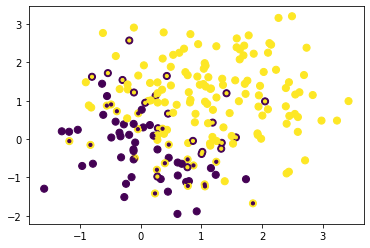

In [87]:
plt.scatter(x[:,0],x[:,1], c=z, s=50)
plt.scatter(x[:,0],x[:,1], c=viterbi_states[0], s=10)

In [93]:
print("error rate: ",(np.array(z)!=np.array(viterbi_states[0])).sum()/sequence_length)

error rate:  0.2
